## STEP 1
### Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

https://dbdiagram.io/d/Fetch-data-model-6791c10037f5d6cbeba3bc62

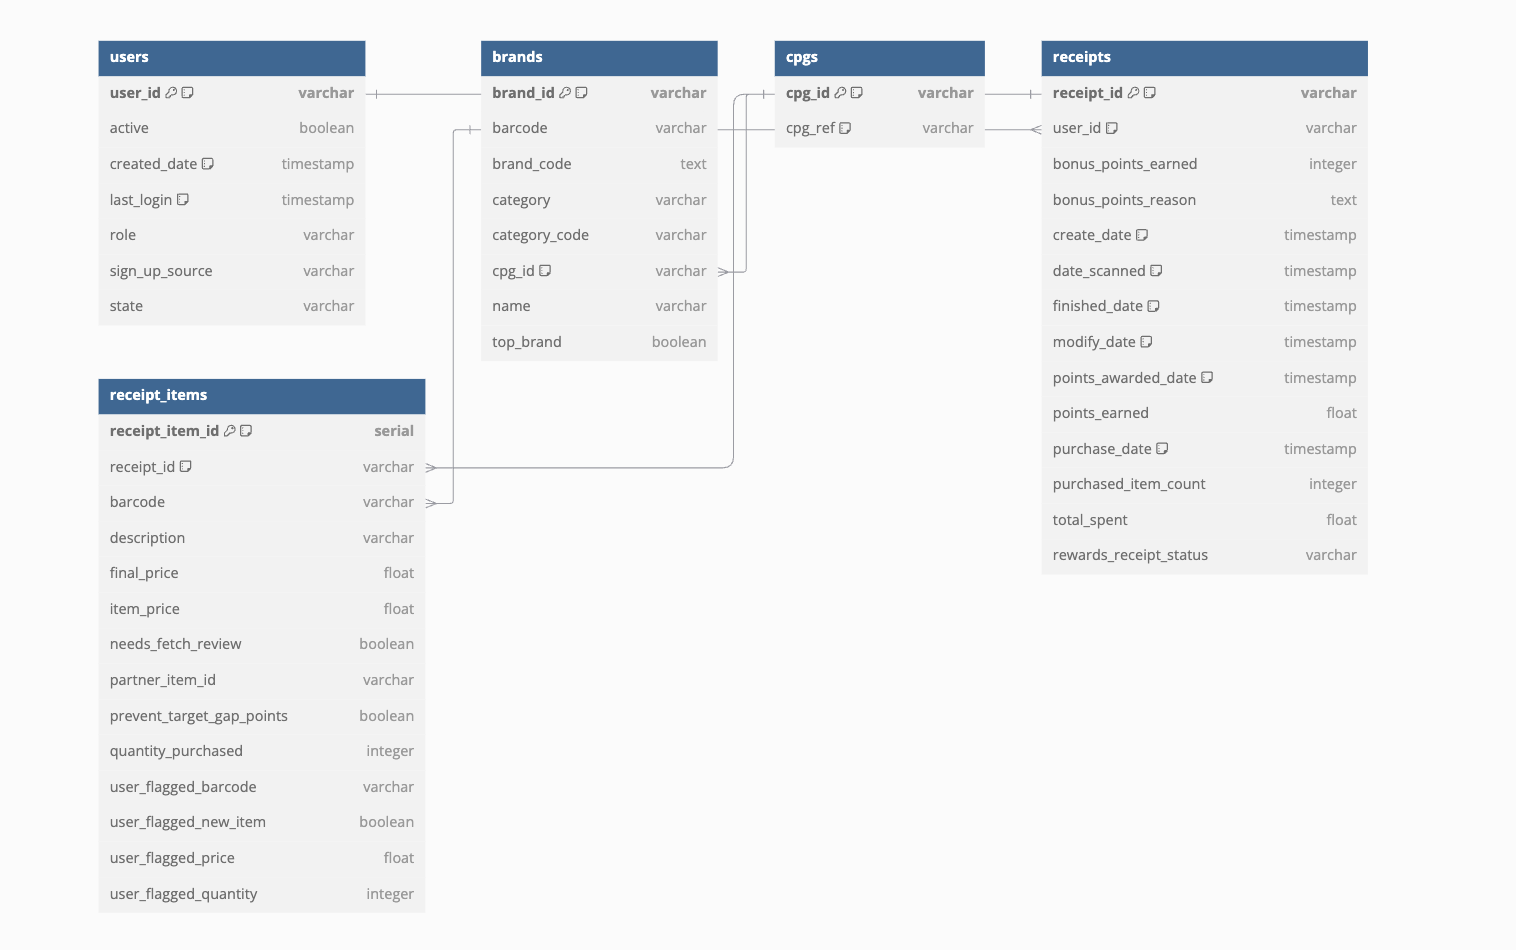

### Load the raw data into the designed data warehouse

In [1]:
import sqlite3
import json
from datetime import datetime
import pandas as pd

In [2]:
# Connect to SQLite database (or create one if it doesn't exist)
conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()

In [3]:
#cursor.execute("DROP TABLE IF EXISTS users")
#cursor.execute("DROP TABLE IF EXISTS cpgs")
#cursor.execute("DROP TABLE IF EXISTS brands")
#cursor.execute("DROP TABLE IF EXISTS receipts")
#cursor.execute("DROP TABLE IF EXISTS receipt_items")

In [4]:
# user table
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
    user_id TEXT PRIMARY KEY,
    active BOOLEAN,
    created_date TEXT,
    last_login TEXT,
    role TEXT,
    state TEXT
)
""")

In [5]:
# cpg table
cursor.execute("""
CREATE TABLE IF NOT EXISTS cpgs (
    cpg_id TEXT PRIMARY KEY,
    cpg_ref TEXT
)
""")

In [6]:
# brand table
cursor.execute("""
CREATE TABLE IF NOT EXISTS brands (
    brand_id TEXT PRIMARY KEY,
    barcode TEXT,
    brand_code TEXT, 
    category TEXT,
    category_code TEXT,
    cpg_id TEXT,
    name TEXT,
    top_brand BOOLEAN,
    FOREIGN KEY (cpg_id) REFERENCES cpgs(cpg_id)
)
""")

In [7]:
# receipt table
cursor.execute("""
CREATE TABLE IF NOT EXISTS receipts (
    receipt_id TEXT PRIMARY KEY,
    user_id TEXT,
    bonus_points_earned INTEGER,
    bonus_points_reason TEXT,
    create_date TEXT,
    date_scanned TEXT,
    finished_date TEXT,
    modify_date TEXT,
    points_awarded_date TEXT,
    points_earned FLOAT,
    purchase_date TEXT,
    purchased_item_count INTEGER,
    total_spent FLOAT,
    rewards_receipt_status TEXT,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
)
""")

In [8]:
# receipt item table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS receipt_items (
    receipt_item_id INTEGER PRIMARY KEY AUTOINCREMENT,
    receipt_id TEXT,  
    barcode TEXT,
    description TEXT,
    final_price FLOAT,
    item_price FLOAT,
    needs_fetch_review BOOLEAN,
    needs_fetch_review_reason TEXT,
    partner_item_id TEXT,
    points_not_awarded_reason TEXT,
    points_payer_id TEXT,
    prevent_target_gap_points BOOLEAN,
    quantity_purchased INTEGER,
    rewards_group TEXT,
    rewards_product_partner_id TEXT,
    user_flagged_barcode TEXT,
    user_flagged_description TEXT,
    user_flagged_new_item BOOLEAN,
    user_flagged_price FLOAT,
    user_flagged_quantity INTEGER,
    FOREIGN KEY (barcode) REFERENCES brands(barcode),
    FOREIGN KEY (receipt_id) REFERENCES receipts(receipt_id)
)
""")

#### Load Users JSON

In [9]:
with open("users.json", "r", encoding="utf-8") as file:
    data = [json.loads(line.strip()) for line in file]

conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()

In [10]:
try:
    for user in data:
        user_id = user["_id"]["$oid"]
        active = user.get("active",None)
        created_date = datetime.fromtimestamp(user["createdDate"]["$date"] / 1000).isoformat()
        
        last_login = user.get("lastLogin", {}).get("$date")
        if last_login:
            last_login = datetime.fromtimestamp(last_login / 1000).isoformat()
        else:
            last_login = None

        role = user.get("role",None)
        state = user.get("state", None)

        cursor.execute("""
        INSERT OR IGNORE INTO users (user_id, active, created_date, last_login, role, state)
        VALUES (?, ?, ?, ?, ?, ?);
        """, (user_id, active, created_date, last_login, role, state))

    conn.commit()
    print("Data successfully inserted into the users table!")
    
except sqlite3.OperationalError as e:
    print("An error occurred:", e)
    
finally:
    conn.close()

Data successfully inserted into the users table!


#### Load Receipts JSON

In [11]:
with open("receipts.json", "r", encoding="utf-8") as file:
    data = [json.loads(line.strip()) for line in file]

conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()

In [12]:
try:
    for receipt in data:
        # receipt
        receipt_id = receipt["_id"]["$oid"]
        bonus_points_earned = receipt.get("bonusPointsEarned",None)
        bonus_points_reason = receipt.get("bonusPointsEarnedReason",None)

        create_date = receipt.get("createdDate", {}).get("$date")
        if create_date:
            create_date = datetime.fromtimestamp(create_date / 1000).isoformat()
        else:
            create_date = None
        
        date_scanned = receipt.get("dateScanned", {}).get("$date")
        if date_scanned:
            date_scanned = datetime.fromtimestamp(date_scanned / 1000).isoformat()
        else:
            date_scanned = None
        
        finished_date = receipt.get("finishedDate", {}).get("$date")
        if finished_date:
            finished_date = datetime.fromtimestamp(finished_date / 1000).isoformat()
        else:
            finished_date = None
            
        modify_date = receipt.get("modifyDate", {}).get("$date")
        if modify_date:
            modify_date = datetime.fromtimestamp(modify_date / 1000).isoformat()
        else:
            modify_date = None
            
        points_awarded_date = receipt.get("pointsAwardedDate", {}).get("$date")
        if points_awarded_date:
            points_awarded_date = datetime.fromtimestamp(points_awarded_date / 1000).isoformat()
        else:
            points_awarded_date = None
        points_earned = receipt.get("pointsEarned",None)

        purchase_date = receipt.get("purchaseDate", {}).get("$date")
        if purchase_date:
            purchase_date = datetime.fromtimestamp(purchase_date / 1000).isoformat()
        else:
            purchase_date = None
        purchased_item_count = receipt.get("purchasedItemCount",None)

        rewards_receipt_status = receipt.get("rewardsReceiptStatus",None)
        total_spent = receipt.get("totalSpent", None)
        user_id = receipt.get("userId", None)

        cursor.execute("""
        INSERT OR IGNORE INTO receipts (receipt_id, bonus_points_earned, bonus_points_reason, create_date, 
                                    date_scanned, finished_date, modify_date, points_awarded_date, points_earned,
                                    purchase_date, purchased_item_count, rewards_receipt_status, total_spent, user_id)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
        """, (receipt_id, bonus_points_earned, bonus_points_reason, create_date, date_scanned, finished_date, 
              modify_date, points_awarded_date, points_earned,purchase_date, purchased_item_count, 
              rewards_receipt_status, total_spent, user_id))

    conn.commit()
    print("Data successfully inserted into the users table!")
    
except sqlite3.OperationalError as e:
    print("An error occurred:", e)
    
finally:
    conn.close()

Data successfully inserted into the users table!


In [13]:
conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()
try:
    for receipt in data:
        #receipt item
        receipt_id = receipt["_id"]["$oid"]
        rewards_items = receipt.get("rewardsReceiptItemList", [])
        for item in rewards_items:
            barcode = item.get("barcode",None)
            description = item.get("description",None)
            final_price = item.get("finalPrice",None)
            item_price = item.get("itemPrice",None)
            needs_fetch_review = item.get("needsFetchReview",None)
            needs_fetch_review_reason = item.get("needsFetchReviewReason",None)
            partner_item_id = item.get("partnerItemId",None)
            points_not_awarded_reason = item.get("pointsNotAwardedReason",None)
            points_payer_id = item.get("pointsPayerId",None)
            prevent_target_gap_points = item.get("preventTargetGapPoints",None)
            quantity_purchased = item.get("quantityPurchased",None)
            rewards_group = item.get("rewardsGroup",None)
            rewards_product_partner_id = item.get("rewardsProductPartnerId",None)
            
            user_flagged_barcode = item.get("userFlaggedBarcode",None)
            user_flagged_description = item.get("userFlaggedDescription",None)
            user_flagged_new_item = item.get("userFlaggedNewItem",None)
            user_flagged_price = item.get("userFlaggedPrice",None)
            user_flagged_quantity = item.get("userFlaggedQuantity",None)
            
            cursor.execute("""INSERT OR IGNORE INTO receipt_items 
                             (receipt_id, barcode, description, final_price, item_price, needs_fetch_review, needs_fetch_review_reason,
                             partner_item_id, points_not_awarded_reason, points_payer_id, prevent_target_gap_points,quantity_purchased,
                             user_flagged_barcode, rewards_group, rewards_product_partner_id, user_flagged_description,
                             user_flagged_new_item, user_flagged_price,user_flagged_quantity)
                             VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);""", 
                           (receipt_id, barcode, description, final_price, item_price, needs_fetch_review, needs_fetch_review_reason,
                             partner_item_id, points_not_awarded_reason, points_payer_id, prevent_target_gap_points,quantity_purchased,
                             user_flagged_barcode, rewards_group, rewards_product_partner_id, user_flagged_description,
                             user_flagged_new_item, user_flagged_price,user_flagged_quantity))
    
    conn.commit()
    print("Data successfully inserted into the users table!")
    
except sqlite3.OperationalError as e:
    print("An error occurred:", e)

finally:
    conn.close()

Data successfully inserted into the users table!


#### Load Brands JSON

In [14]:
with open("brands.json", "r", encoding="utf-8") as file:
    data = [json.loads(line.strip()) for line in file]

conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()

In [15]:
try:
    for brand in data:
        brand_id = brand["_id"]["$oid"]
        barcode = brand.get("barcode",None)
        brand_code = brand.get("brandCode",None)
        category = brand.get("category",None)
        category_code = brand.get("categoryCode",None)

        cpg = brand.get("cpg", {})
        cpg_id = cpg.get("$id", {}).get("$oid", None) if isinstance(cpg, dict) else None
        cpg_ref = cpg.get("$ref", None) if isinstance(cpg, dict) else None
        
        name = brand.get("name", None)
        top_brand = brand.get("topBrand", None)

        cursor.execute("""
        INSERT OR IGNORE INTO brands (brand_id, barcode, brand_code, category, cpg_id, category_code, name, top_brand)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?);
        """, (brand_id, barcode, brand_code, category, cpg_id, category_code, name, top_brand))
        
        cursor.execute("""
        INSERT OR IGNORE INTO cpgs (cpg_id, cpg_ref)
        VALUES (?, ?);
        """, (cpg_id, cpg_ref))
        

    conn.commit()
    print("Data successfully inserted into the users table!")
    
except sqlite3.OperationalError as e:
    print("An error occurred:", e)
    
finally:
    conn.close()

Data successfully inserted into the users table!


## STEP 2
### Write queries that directly answer predetermined questions from a business stakeholder

* When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [16]:
# accepted -> "FINISHED"
# rejected -> "REJECTED"
# according to the result, the spead of 'Accepted' is greater
conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()
cursor.execute("""
    SELECT rewards_receipt_status, AVG(total_spent) AS average_spent
    FROM receipts 
    WHERE rewards_receipt_status IN ('FINISHED', 'REJECTED')
    GROUP BY rewards_receipt_status
    ORDER BY average_spent DESC;
""")

cursor.fetchall()

[('FINISHED', 80.85430501930502), ('REJECTED', 23.326056338028184)]

* When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [17]:
# accepted -> "FINISHED"
# rejected -> "REJECTED"
# according to the result, the total number of items purchased with 'Accepted' is greater
cursor.execute("""
    SELECT rewards_receipt_status, SUM(purchased_item_count) AS total_items_purchased
    FROM receipts 
    WHERE rewards_receipt_status IN ('FINISHED', 'REJECTED')
    GROUP BY rewards_receipt_status
    ORDER BY total_items_purchased DESC;
""")

cursor.fetchall()

[('FINISHED', 8184), ('REJECTED', 173)]

## STEP 3
### Evaluate Data Quality Issues in the Data Provided

In [18]:
conn = sqlite3.connect("data_warehouse.db")

users_df = pd.read_sql_query("SELECT * FROM users", conn)
brands_df = pd.read_sql_query("SELECT * FROM brands", conn)
receipts_df = pd.read_sql_query("SELECT * FROM receipts", conn)
receipt_items_df = pd.read_sql_query("SELECT * FROM receipt_items", conn)

conn.close()

#### Check for missing values

In [19]:
missing_users = users_df.isnull().sum()
missing_brands = brands_df.isnull().sum()
missing_receipts = receipts_df.isnull().sum()
missing_items = receipt_items_df.isnull().sum()

print("Missing brands：\n", missing_brands)
print("Missing receipts：\n", missing_receipts)
print("Missing Receipt Items：\n", missing_items)

Missing brands：
 brand_id           0
barcode            0
brand_code       234
category         155
category_code    650
cpg_id             0
name               0
top_brand        612
dtype: int64
Missing receipts：
 receipt_id                   0
user_id                      0
bonus_points_earned        575
bonus_points_reason        575
create_date               1119
date_scanned                 0
finished_date              551
modify_date                  0
points_awarded_date        582
points_earned              510
purchase_date              448
purchased_item_count       484
total_spent                435
rewards_receipt_status       0
dtype: int64
Missing Receipt Items：
 receipt_item_id                   0
receipt_id                        0
barcode                       11553
description                    1143
final_price                     522
item_price                      522
needs_fetch_review            18384
needs_fetch_review_reason     20166
partner_item_id         

In [20]:
conn = sqlite3.connect("data_warehouse.db")
cursor = conn.cursor()
cursor.execute("""
    SELECT distinct(substr(date_scanned, 1, 7)) AS month_scanned 
    FROM receipts
    ORDER BY month_scanned ;
""")

cursor.fetchall()

[('2020-10',), ('2020-11',), ('2021-01',), ('2021-02',), ('2021-03',)]

### Check for duplicates

In [21]:
duplicates = users_df[users_df.duplicated(subset=["user_id"], keep=False)]
print("Duplicate USER IDs:",duplicates)

Duplicate USER IDs: Empty DataFrame
Columns: [user_id, active, created_date, last_login, role, state]
Index: []


In [22]:
duplicates = brands_df[brands_df.duplicated(subset=["brand_id"], keep=False)]
print("Duplicate Brand IDs:",duplicates)

Duplicate Brand IDs: Empty DataFrame
Columns: [brand_id, barcode, brand_code, category, category_code, cpg_id, name, top_brand]
Index: []


In [23]:
duplicates = receipts_df[receipts_df.duplicated(subset=["receipt_id"], keep=False)]
print("Duplicate Brand IDs:",duplicates)

Duplicate Brand IDs: Empty DataFrame
Columns: [receipt_id, user_id, bonus_points_earned, bonus_points_reason, create_date, date_scanned, finished_date, modify_date, points_awarded_date, points_earned, purchase_date, purchased_item_count, total_spent, rewards_receipt_status]
Index: []


### Check for abnormal price

In [24]:
abnormal_prices = receipt_items_df[(receipt_items_df["final_price"] < 0) | (receipt_items_df["final_price"] > 10000)]
print("\nAbnormal Prices in Receipt Items:")
print(abnormal_prices)


Abnormal Prices in Receipt Items:
Empty DataFrame
Columns: [receipt_item_id, receipt_id, barcode, description, final_price, item_price, needs_fetch_review, needs_fetch_review_reason, partner_item_id, points_not_awarded_reason, points_payer_id, prevent_target_gap_points, quantity_purchased, rewards_group, rewards_product_partner_id, user_flagged_barcode, user_flagged_description, user_flagged_new_item, user_flagged_price, user_flagged_quantity]
Index: []


### Check for invalid barcode (no matching barcode)

In [25]:
irrelevant_items = pd.read_sql_query("""
    SELECT ri.*
    FROM receipt_items AS ri
    LEFT JOIN brands AS b ON ri.barcode = b.barcode
    WHERE b.barcode IS NULL
""", conn)
print("\nIrrelevant Receipt Items (No Matching Barcode):",irrelevant_items)



Irrelevant Receipt Items (No Matching Barcode):        receipt_item_id                receipt_id       barcode  \
0                    1  5ff1e1eb0a720f0523000575          4011   
1                    2  5ff1e1bb0a720f052300056b          4011   
2                    3  5ff1e1bb0a720f052300056b  028400642255   
3                    4  5ff1e1f10a720f052300057a          None   
4                    5  5ff1e1ee0a7214ada100056f          4011   
...                ...                       ...           ...   
20572            20819  603cc2bc0a720fde100003e9    B07BRRLSVC   
20573            20820  603cc0630a720fde100003e6    B076FJ92M4   
20574            20821  603cc0630a720fde100003e6    B07BRRLSVC   
20575            20822  603ce7100a7217c72c000405    B076FJ92M4   
20576            20823  603ce7100a7217c72c000405    B07BRRLSVC   

                                             description  final_price  \
0                                         ITEM NOT FOUND        26.00   
1           

### Statistic

In [26]:
receipts_df.describe()

,bonus_points_earned,points_earned,purchased_item_count,total_spent
count,544.000000,609.000000,635.00000,684.000000
mean,238.893382,585.962890,14.75748,77.796857
std,299.091731,1357.166947,61.13424,347.110349
min,5.000000,0.000000,0.00000,0.000000
25%,5.000000,5.000000,1.00000,1.000000
50%,45.000000,150.000000,2.00000,18.200000
75%,500.000000,750.000000,5.00000,34.960000
max,750.000000,10199.800000,689.00000,4721.950000


In [27]:
receipt_items_df.describe()

,receipt_item_id,final_price,item_price,needs_fetch_review,prevent_target_gap_points,quantity_purchased,user_flagged_new_item,user_flagged_price,user_flagged_quantity
count,20823.000000,20301.000000,20301.000000,2439.000000,1074.0,20301.000000,969.0,897.000000,897.000000
mean,10412.000000,7.871661,7.872178,0.269373,1.0,1.386139,1.0,22.780870,1.872910
std,6011.226664,14.656054,14.655901,0.443725,0.0,1.204304,0.0,9.267598,1.313355
min,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000
25%,5206.500000,2.290000,2.290000,0.000000,1.0,1.000000,1.0,21.000000,1.000000
50%,10412.000000,4.280000,4.280000,0.000000,1.0,1.000000,1.0,28.000000,1.000000
75%,15617.500000,9.990000,9.990000,1.000000,1.0,1.000000,1.0,29.000000,3.000000
max,20823.000000,441.580000,441.580000,1.000000,1.0,17.000000,1.0,29.000000,5.000000


## STEP 4
Hi, I’ve been analyzing the data we’re working with for the project, and I’d like to share some findings and questions related to data quality, along with proposed next steps.  

#### Key Observations  
1. **Data Quality Issues**:  
   - A significant number of missing values were identified, particularly in critical fields like `date_scanned` and product descriptions like `barcode`. Missing dates make it difficult to track when receipts were processed, as well as to link the tables together. This can impact downstream reporting.  
   - Inconsistent entries, such as non-standardized product `descriptions` and `bonus points earned reasons`, were also observed.

2. **Discovery Process**:  
   - These issues were uncovered using exploratory data analysis, including checks for missing values and statistic analysis.  

#### Questions and Information Needed   
- What are the acceptable thresholds for missing or invalid data? If we keep all the data with invaild valuses for importnt variables (like `date_scanned`), can we try imputation?  
- Are there documented we can use to validate key fields for products like `item_price` or fill in the product descriptions by ourselves?   

#### Additional Context for Optimization   
- Feedback from stakeholders on which dimensions of the data are most critical
- A clear understanding of how this data will be used. If it is for reporting or decision making, who would be the audiences? 
- Access to data dictionary that outlines the expected format, constraints, and the business meaning for each field.  

#### Anticipated Production Challenges  
- **Performance**: Large datasets with complex joins or aggregations could slow down queries.   
- **Scaling**: As data volume grows, we need to ensure our infrastructure can handle increased storage and compute requirements. Leveraging cloud-based solutions with auto-scaling capabilities would help mitigate this.  
- **Data Integrity**: Automated data quality checks should be implemented to catch issues early. Tools like data pipelines with validation steps can be useful here.  

#### Next Steps   
- Implement a plan to clean, standardize, and validate critical fields in the dataset.  
- Set up automated monitoring and alerts to flag future data quality issues.  